In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Explore Data

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [13]:
engine.execute('SELECT * FROM station LIMIT 5').keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Climate Analysis

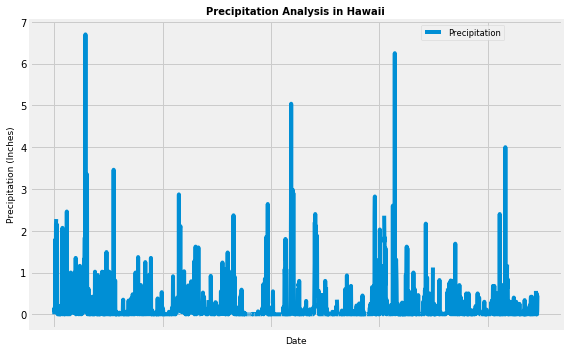

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
recent_date = session.query(Measurement.date)\
    .order_by(Measurement.date.desc()).first()
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
rain_df = pd.DataFrame(precipitation)
rain_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date','prcp', figsize=(8,5))
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel("Date", size=9)
plt.ylabel("Precipitation (Inches)", size=9)
plt.title("Precipitation Analysis in Hawaii", fontweight='bold', size=10)
plt.legend(["Precipitation"],loc=1, fontsize='small', bbox_to_anchor=(.90, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Prcp-plot.png")
plt.show()

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station = active[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == active_station).all()

[(54.0, 85.0, 71.66378066378067)]

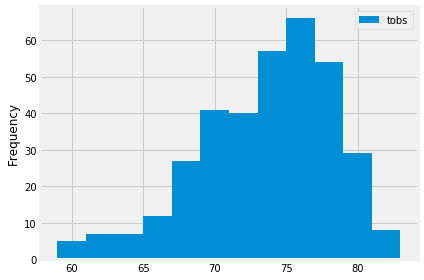

In [29]:
# Choose the station with the highest number of temperature observations.
temp_data = session.query(Measurement.tobs).\
                filter(Measurement.date >= last_year).\
                filter(Measurement.station == active_station).all()
temp_df = pd.DataFrame(temp_data)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp_df['tobs'], bins=12)
plt.ylabel("Frequency", fontsize=12)
labels = ['tobs']
plt.legend(labels)
plt.tight_layout()
plt.savefig("Frequency.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-07-03', '2017-07-14')

trip_df = pd.DataFrame(my_trip, columns=['t_min', 't_avg', 't_max'])
trip_df

,t_min,t_avg,t_max
0,69.0,78.090909,87.0


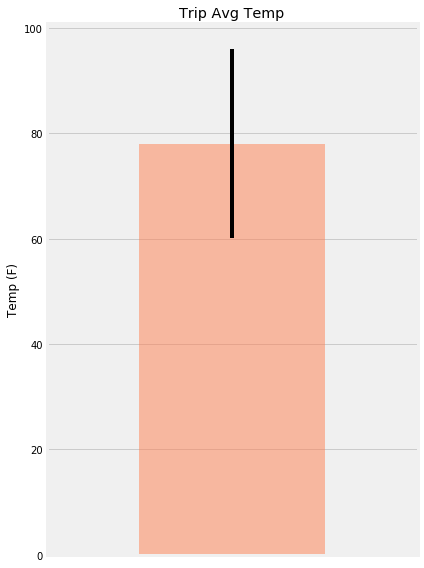

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='t_avg', 
                yerr=(trip_df['t_max'] - trip_df['t_min']),
                title='Trip Avg Temp', 
                color='coral', 
                alpha=0.5, 
                figsize=(6,8))

plt.xticks([])
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("avg-temp.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-03', '2017-07-14'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.15), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start = '2017-07-03'
end =  '2017-07-14'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start, end)

# Stip off the year and save a list of %m-%d strings
trip_dates = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_results = []
for i in trip_dates:
    daily_results.append(*daily_normals(i))
daily_results

[(68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_df = pd.DataFrame(daily_results, columns=['Min Temp','Avg Temp','Max Temp'])

# now add those dates back into the dataframe
daily_df['Date'] = trip_dates

daily_df = daily_df.set_index('Date')

daily_df

,Min Temp,Avg Temp,Max Temp
Date,,,
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0


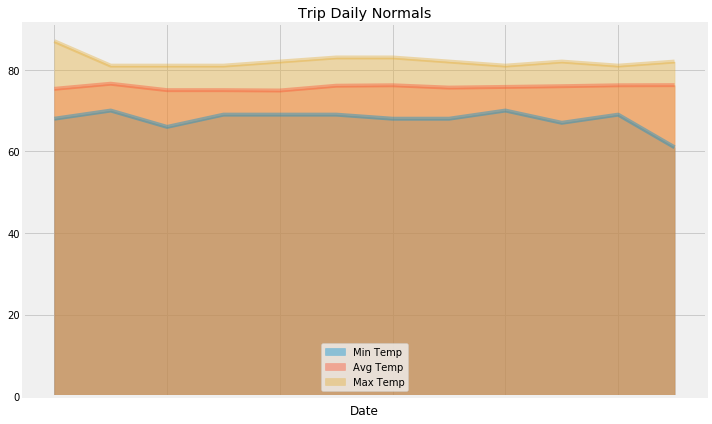

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot(kind='area', stacked = False, alpha=0.4, x_compat=True, title="Trip Daily Normals", figsize=(10,6))
plt.legend(loc = "lower center")
plt.xticks(rotation=40)
plt.tight_layout()
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.savefig("normals.png")
plt.show()